In [ ]:
def train_loop(args, labeled_loader, unlabeled_loader, test_loader,
               teacher_model, student_model, avg_student_model, criterion,
               t_optimizer, s_optimizer, t_scheduler, s_scheduler, t_scaler, s_scaler):

In [ ]:
    labeled_iter = iter(labeled_loader)
    unlabeled_iter = iter(unlabeled_loader)

In [ ]:
    step = 0
    for step in range(args.start_step, args.total_steps):

In [ ]:
        teacher_model.train()
        student_model.train()
        
        images_l, targets = labeled_iter.next()
        (images_uw, images_us), _ = unlabeled_iter.next()
        
        images_l = images_l.to(args.device)
        images_uw = images_uw.to(args.device)
        images_us = images_us.to(args.device)
        targets = targets.to(args.device)


## teacher 모델의 labeled 데이터에 대한 loss

In [ ]:
        batch_size = images_l.shape[0]
        t_images = torch.cat((images_l, images_uw, images_us))
        t_logits = teacher_model(t_images)
        t_logits_l = t_logits[:batch_size]
        t_logits_uw, t_logits_us = t_logits[batch_size:].chunk(2)
        del t_logits

        t_loss_l = criterion(t_logits_l, targets)

## teacher 모델을 통해 unlabeled 데이터에 대한 pseudo label 생성

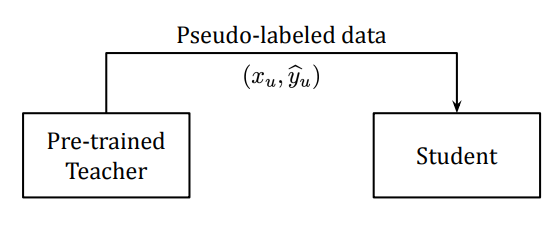

In [4]:
from IPython.display import Image
Image("C:/Users/maeng/Desktop/캡처3.png")

In [ ]:
        soft_pseudo_label = torch.softmax(t_logits_uw.detach()/args.temperature, dim=-1)
        max_probs, hard_pseudo_label = torch.max(soft_pseudo_label, dim=-1)
        mask = max_probs.ge(args.threshold).float()
        t_loss_u = torch.mean(
            -(soft_pseudo_label * torch.log_softmax(t_logits_us, dim=-1)).sum(dim=-1) * mask
        )
        weight_u = args.lambda_u * min(1., (step+1) / args.uda_steps)
        t_loss_uda = t_loss_l + weight_u * t_loss_u

## pseudo labels을 이용해 student model 학습

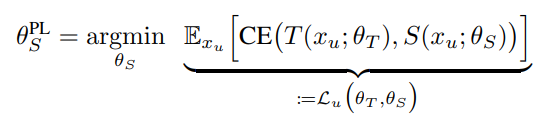

In [2]:
from IPython.display import Image
Image("C:/Users/maeng/Desktop/캡처1.png")

In [ ]:
        s_images = torch.cat((images_l, images_us))
        s_logits = student_model(s_images)
        s_logits_l = s_logits[:batch_size]
        s_logits_us = s_logits[batch_size:]
        del s_logits

        s_loss_l_old = F.cross_entropy(s_logits_l.detach(), targets.to(torch.long))
        s_loss = criterion(s_logits_us, hard_pseudo_label) #수식 1번

In [ ]:
        s_scaler.scale(s_loss).backward()
        if args.grad_clip > 0:
            s_scaler.unscale_(s_optimizer)
            nn.utils.clip_grad_norm_(student_model.parameters(), args.grad_clip)
        s_scaler.step(s_optimizer)
        s_scaler.update()
        s_scheduler.step()

## student 모델의 labeled 데이터에 대해 다시 loss 계산

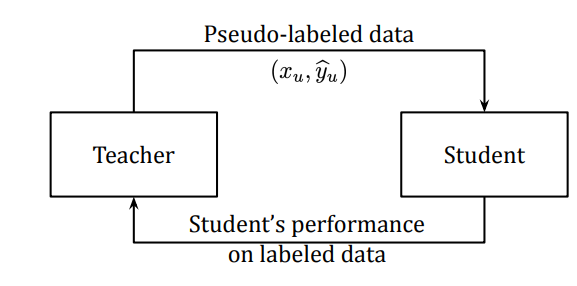

In [3]:
Image("C:/Users/maeng/Desktop/캡처2.png")

In [ ]:
        with torch.no_grad():
            s_logits_l = student_model(images_l)
        s_loss_l_new = F.cross_entropy(s_logits_l.detach(), targets.to(torch.long))
        dot_product = s_loss_l_old - s_loss_l_new

        #teacher 모델에 student 모델의 labeled data에 대한 loss 전달
        _, hard_pseudo_label = torch.max(t_logits_us.detach(), dim=-1)
        t_loss_mpl = dot_product * F.cross_entropy(t_logits_us, hard_pseudo_label)
        t_loss = t_loss_uda + t_loss_mpl

## teacher 모델 update

In [ ]:
        t_scaler.scale(t_loss).backward()
        if args.grad_clip > 0:
            t_scaler.unscale_(t_optimizer)
            nn.utils.clip_grad_norm_(teacher_model.parameters(), args.grad_clip)
        t_scaler.step(t_optimizer)
        t_scaler.update()
        t_scheduler.step()